In [12]:
dsi_dg_threshold = 0.5
ecid = 511510650
eid = 501717543
# 501836392 501886692 501717543

In [13]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]


In [14]:
pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,109,Cux2-CreERT2,222425,511510650,False,501886692,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
1,108,Cux2-CreERT2,222425,511510650,True,501836392,175,Ai93(TITL-GCaMP6f),three_session_A,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
2,104,Cux2-CreERT2,222425,511510650,True,501717543,175,Ai93(TITL-GCaMP6f),three_session_C,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp


In [15]:
dg_response_filter = get_dg_response_filter_from_saskia()
filtered_cells = get_filtered_cells(cells, dg_response_filter)
filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_dg_threshold]
dirs = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]
dirs_to_avg_pairwise_corr = {}
for d1 in dirs:
    for d2 in dirs:
        avg_corr, num_pairs, num_group1, num_group2 = pairwise_dir_avg_temp_corr_one_exp(
            boc, ecid, eid, d1, d2, filtered_cells,
            # use_events
            True,
            # noise_corr_else_avg_temp_corr
            True)
        if avg_corr is None:
            continue
        dirs_to_avg_pairwise_corr[(d1, d2)] = avg_corr
        print ("d1", d1, "d2", d2, "corr", avg_corr, "num_pairs", num_pairs, "num_group1", num_group1, "num_group2", num_group2)

d1 0.0 d2 0.0 corr -0.2809024316270686 num_pairs 2 num_group1 6 num_group2 6
d1 0.0 d2 45.0 corr -0.10265314173155562 num_pairs 4 num_group1 6 num_group2 6
d1 0.0 d2 90.0 corr 0.06808367330735104 num_pairs 2 num_group1 6 num_group2 3
d1 0.0 d2 135.0 corr 0.012724380029981303 num_pairs 2 num_group1 6 num_group2 1
d1 0.0 d2 225.0 corr -0.035259440958667586 num_pairs 14 num_group1 6 num_group2 9
d1 0.0 d2 270.0 corr 0.20788437961644687 num_pairs 4 num_group1 6 num_group2 4
d1 0.0 d2 315.0 corr -0.18944770975262903 num_pairs 6 num_group1 6 num_group2 6
d1 45.0 d2 0.0 corr -0.10265314173155562 num_pairs 4 num_group1 6 num_group2 6
d1 45.0 d2 45.0 corr -0.13224924710866093 num_pairs 2 num_group1 6 num_group2 6
d1 45.0 d2 90.0 corr 0.46969888455752723 num_pairs 2 num_group1 6 num_group2 3
d1 45.0 d2 135.0 corr 0.31949766333688273 num_pairs 2 num_group1 6 num_group2 1
d1 45.0 d2 225.0 corr 0.07809042059625648 num_pairs 14 num_group1 6 num_group2 9
d1 45.0 d2 270.0 corr 0.001294895263419124 num

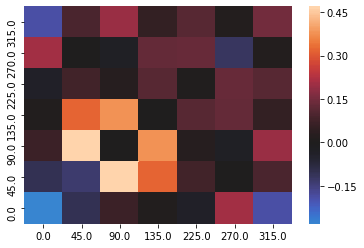

In [17]:
import seaborn as sns;
ser = pd.Series(list(dirs_to_avg_pairwise_corr.values()),
                  index=pd.MultiIndex.from_tuples(dirs_to_avg_pairwise_corr.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

In [18]:
# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dirs_to_avg_pairwise_corr:
            dir_partner_to_corr[dir2] = dirs_to_avg_pairwise_corr[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

0.0 [270.0, 90.0, 135.0, 225.0, 45.0, 315.0, 0.0]
45.0 [90.0, 135.0, 315.0, 225.0, 270.0, 0.0, 45.0]
90.0 [45.0, 135.0, 315.0, 0.0, 225.0, 270.0]
135.0 [90.0, 45.0, 270.0, 225.0, 315.0, 0.0]
180.0 []
225.0 [270.0, 315.0, 135.0, 45.0, 90.0, 225.0, 0.0]
270.0 [0.0, 225.0, 135.0, 315.0, 45.0, 90.0, 270.0]
315.0 [90.0, 315.0, 225.0, 45.0, 135.0, 270.0, 0.0]
